In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from os.path import abspath
from os import chdir
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS

In [4]:
joined_df = pd.read_csv('joined_df.csv', header=0)

In [5]:
joined_df = joined_df.set_index('Date Local')

In [6]:
chdir(abspath('../'))

In [7]:
abspath('')

'/mnt/c/Users/Rajkumar/OneDrive - The George Washington University/Time Series Analysis'

In [8]:
from Utilities.GPAC import gpac_table
from Utilities.WhitenessTest import WhitenessTest as WT

In [9]:
def whiteness_test(x, name):
    wt = WT(x)
    print(f"ADF test for {name}:\n")
    wt.ADF_Cal()
    wt.Plot_Rolling_Mean_Var(name="name")

In [10]:
def seasonal_differencing(y, seasonal_period):
    m = seasonal_period
    s_diff = []
    for t in range(m, len(y)):
        s_diff.append(y[t] - y[t-m])
    return s_diff

In [11]:
def print_strength_seas_tren(x, name):
    stl = STL(x, period=12).fit()
    residual = stl.resid
    trend = stl.trend
    seasonal = stl.seasonal
    f_t = np.max([0, 1-(np.var(residual)/np.var(residual + trend))]) # denominator = seasonally adjusted data
    f_s = np.max([0, 1-(np.var(residual)/np.var(residual + seasonal))]) # denominator = detrended data
    print(f"Strength of trend in {name} is: {f_t * 100}%")
    print(f"Strength of seasonality in {name} is {f_s * 100}%")

In [12]:
def plot_acf_pacf(x, lags, xlims=None):
    r_idx = 0
    if xlims:
        fig, axes = plt.subplots(len(xlims), 2, sharex=False, sharey=True, figsize=(15, 10))
        for xlim in xlims:
            plot_acf(x, lags=lags, ax=axes[r_idx, 0])
            plot_pacf(x, lags=lags, ax=axes[r_idx, 1])
            axes[r_idx, 0].set_xlim(xlim)
            axes[r_idx, 1].set_xlim(xlim)
            r_idx += 1
    else:
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11, 5))
        plot_acf(x, lags=lags, ax=axes[0])
        plot_pacf(x, lags=lags, ax=axes[1])
    plt.tight_layout()
    plt.show()

In [13]:
joined_df['CO AQI'].head()

Date Local
2000-01-01    25.0
2000-01-02    26.0
2000-01-03    28.0
2000-01-04    34.0
2000-01-05    42.0
Name: CO AQI, dtype: float64

In [16]:
co = joined_df['CO AQI']

train_test_split = round(0.7 * co.shape[0])
co_train = co.iloc[:train_test_split]
co_test = co.iloc[train_test_split:]

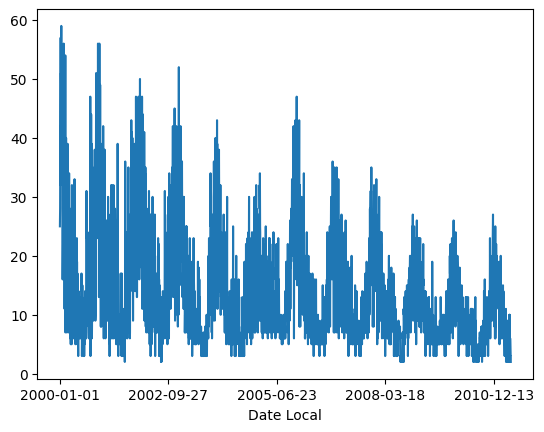

In [18]:
co_train.plot()
plt.show()

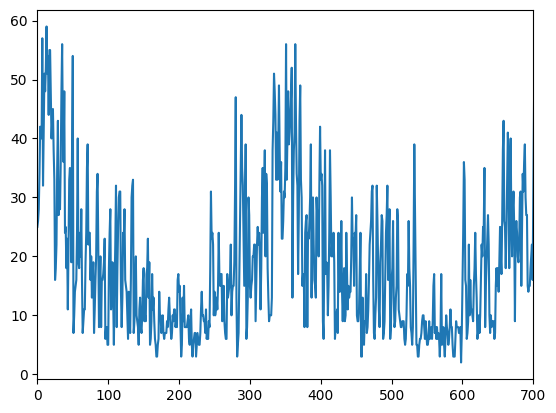

In [22]:
plt.figure()
plt.plot(co_train.reset_index(drop=True).values)
plt.xlim([0, 700])
plt.show()

## Find the seasonality period using grid-search

In [135]:
# Iterate over different seasonality period and try fitting Holts Winter Seasonal method. Pick the
# seasonality period that yields the minimal MSE value.
# """
#
mse_list_co = [np.Inf, np.Inf]

for i in range(2, 400):
    ets_co = ETS(co_train, trend=None, damped_trend=False,
                                      seasonal="mul", seasonal_periods=i).fit()
    y_true = co_test.reset_index(drop=True).values.reshape([-1])
    y_pred = ets_co.forecast(steps=co_test.shape[0])
    diff = y_true - y_pred
    mse = 1/len(diff) * (diff.T @ diff)
    mse_list_co.append(mse)

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

In [137]:
seasonal_period = np.argmin(mse_list_co) + 2 # +2 because the range starts from 2

In [139]:
print(f"seasonality period: {seasonal_period}")

seasonality period: 375


In [140]:
ets = ETS(endog=co_train, seasonal='mul', seasonal_periods=375,
          trend=None).fit()

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [150]:
yhat = ets.predict(start=0, end=co_train.shape[0]-1)

In [153]:
yhat.index.max()

'2011-05-17'

In [154]:
co_train.index.max()

'2011-05-17'

In [155]:
yhat.shape

(4156,)

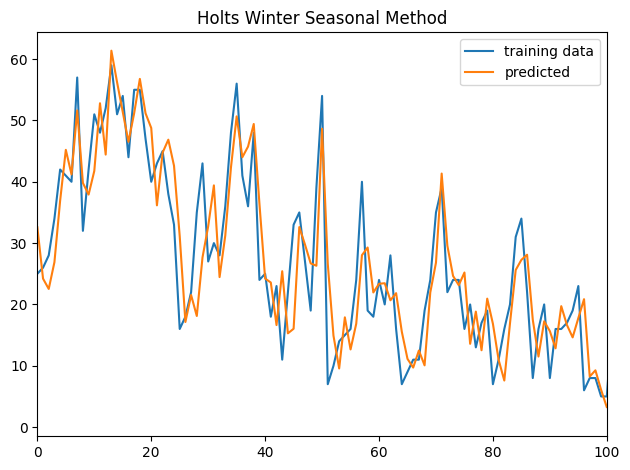

In [161]:
plt.figure()
plt.plot(co_train.reset_index(drop=True), label='training data')
plt.plot(yhat.reset_index(drop=True), label='predicted')
plt.xlim([0, 100])
plt.title('Holts Winter Seasonal Method')
plt.legend()
plt.tight_layout()
plt.show()

In [162]:
yhat.shape

(4156,)

In [163]:
co_train.iloc[:-1].shape

(4155,)

In [164]:
residuals = co_train - yhat

In [165]:
co_train

Date Local
2000-01-01    25.0
2000-01-02    26.0
2000-01-03    28.0
2000-01-04    34.0
2000-01-05    42.0
              ... 
2011-05-13     5.0
2011-05-14     3.0
2011-05-15     3.0
2011-05-16     3.0
2011-05-17     2.0
Name: CO AQI, Length: 4156, dtype: float64

In [166]:
yhat

Date Local
2000-01-01    32.582817
2000-01-02    24.208205
2000-01-03    22.527644
2000-01-04    26.897384
2000-01-05    36.909917
                ...    
2011-05-13     4.307390
2011-05-14     5.489540
2011-05-15     3.301831
2011-05-16     2.478268
2011-05-17     2.760668
Length: 4156, dtype: float64

In [167]:
residuals

Date Local
2000-01-01   -7.582817
2000-01-02    1.791795
2000-01-03    5.472356
2000-01-04    7.102616
2000-01-05    5.090083
                ...   
2011-05-13    0.692610
2011-05-14   -2.489540
2011-05-15   -0.301831
2011-05-16    0.521732
2011-05-17   -0.760668
Length: 4156, dtype: float64

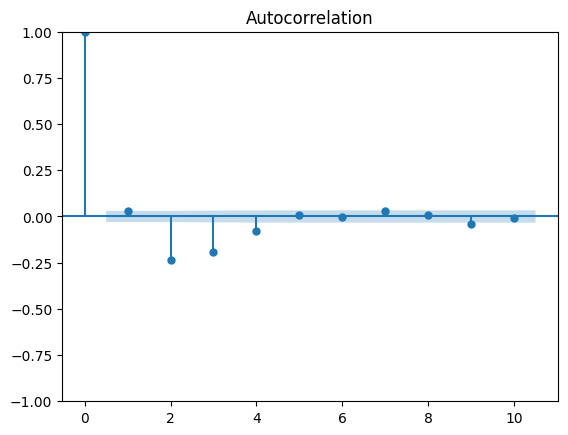

In [168]:
plot_acf(residuals, lags=10)
plt.show()